**In this notebook, we will:**
1. find out the size of our database *before pruning*,
2. show how to open and display WSIs from .ndpi files, and
3. pair up IHC slides with their HE counterparts and save the pairs in a dictionary

# Imports and preparations

This cell might produce some non-fatal warnings. Ignore them until you run into problems:

In [ ]:
import matplotlib
matplotlib.use('agg')

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import pathlib
from pathlib import Path
Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

import pandas as pd
import PIL
import sys

sys.path.append('wsi_processing_pipeline')
sys.path.append('wsi_processing_pipeline/tile_extraction')
sys.path.append('/opt/conda/lib/python3.7/site-packages')

import slide, filter, tiles, util
import matplotlib.pyplot as plt

In [ ]:
output_path = Path('Output')
output_path.mkdir(exist_ok=True)

In [ ]:
import re

These are the paths where we keep our .ndpi files:

In [5]:
base_path = Path('/home/Deep_Learner/private/Hypophysenadenome/')
path_corticotrop = base_path/'corticotrop'
path_gonadotrop = base_path/'gonadotrop'

# Exploring gonadotropic slides

## Getting the names of slides and cases

**PLEASE NOTE:** For reasons of privacy protection, all case names were removed in these notebooks. Whenever sensible, we will use **useful pseudonyms**.

Nonetheless, this section explored these case names. The cells were left as they were, in case the approach and functions might be useful for future researchers.

We're starting with the gonadotropics

In [6]:
fnames = [f for f in pathlib.Path(path_gonadotrop).iterdir() if f.is_file()]
fnames.sort()
fnames[:5]

In [7]:
len(fnames)

862

In [8]:
str(path_gonadotrop)

'/home/Deep_Learner/private/Hypophysenadenome/gonadotrop'

Now let's strip the filenames of their path prefix, and throw out anything that is **not** a .ndpi file:

In [9]:
wsinames = []
for fname in fnames:
    match1 = re.search(
    '(?<=' + str(path_gonadotrop) + '/)(.+)\.ndpi',
    str(fname))
    if match1:
        wsinames.append(match1.group(1))
len(wsinames), wsinames[:5]

In [10]:
wsinames.sort()

This is the reasoning behind the file names:
- **first number**: serial number per year
- **second number**: year
- **roman number/"Z"**: number of the fraction. One could theoretically have several fractions, but in our case, they don't.

Example: **"1-1970-I-HE.ndpi"**

Next, let's strip the wsinames of their stain-suffix (i.e. "-HE", "-FSH", "-LH")

In [11]:
wsinameRE = '(.+)(\-.+)'
match2 = re.search(
wsinameRE,
'975-14-Z-HE')
match2.group(1)

In [12]:
wsi_names_condensed = []
for wsiname in wsinames:
    match2 = re.search(
        '(.+)(\-.+)',
        wsiname)
    if match2:
        wsi_names_condensed.append(match2.group(1))
    else:
        print("Couldn't match "+wsiname)
wsi_names_condensed[:5]

In [13]:
len(wsi_names_condensed)

643

Good, we didn't lose any names. How many unique fractions (i.e., cases) do we have now?

In [14]:
wsi_names_condensed_unique = list(set(wsi_names_condensed))
len(wsi_names_condensed_unique)

230

Now we want to know: Are there any slide name prefixes that only appear **once**?

In [15]:
for wsi_n_c_u in wsi_names_condensed_unique:
    if wsi_names_condensed.count(wsi_n_c_u) == 1:
        print("Found '" + wsi_n_c_u + "'")

The slides of interest are: `'abc-xyz-I-FSH', 'abc-xyz-Z-HE'`

Let's take a look at them.

## Opening and displaying slides

Here's how to get slide objects:

In [16]:
fsh_slide1 = slide.open_slide(path_gonadotrop/'abc-xyz-I-FSH.ndpi')
he_slide1 = slide.open_slide(path_gonadotrop/'abc-xyz-Z-HE.ndpi')

Let's look at the FSH slide at the second-lowest level of resolution:

In [17]:
fsh_level = len(fsh_slide1.level_dimensions)-2
fsh_level

8

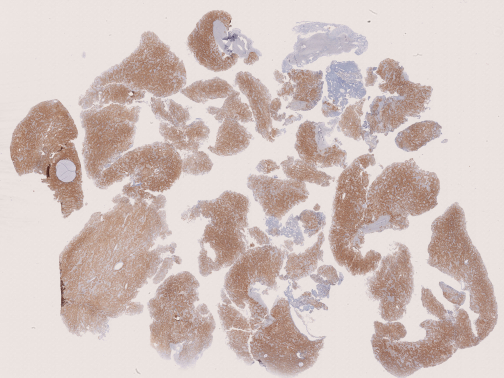

In [18]:
fsh_slide1.read_region((0,0),
                     fsh_level,
                     fsh_slide1.level_dimensions[fsh_level])

Great!

Does the LH slide include the same level of resolution?

In [19]:
len(he_slide1.level_dimensions)

9

It does. Then let's look at it on the same level:

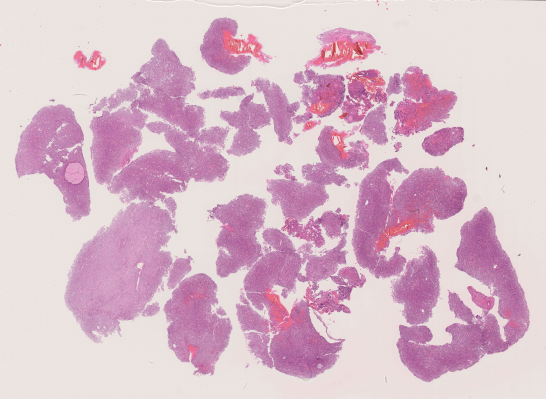

In [20]:
he_slide1.read_region((0,0),
                     fsh_level,
                     he_slide1.level_dimensions[fsh_level])

We see: The slides show the same region. So they're a match, despite their difference in the roman number (i.e., their fraction identifier).

## Identifying our key

Finally, to generate pairs of slides, we want to find out one more thing:

Is the fraction number (the Roman number suffix) a distinctive feature, or do the first two numbers alone constitute a valid "key"?

In [21]:
wsi_names_two_numbers = []
for wsi_n_c_u in wsi_names_condensed_unique:
    m3 = re.search(
        '(.+)(\-.+)',
        wsi_n_c_u)
    if m3:
        wsi_names_two_numbers.append(m3.group(1))
    else:
        print("Couldn't match "+wsi_n_c_u)
wsi_names_two_numbers[:5]

In [22]:
wsi_names_two_numbers = list(set(wsi_names_two_numbers))
len(wsi_names_two_numbers)

229

Thus: All slide groups are identifiable through the first two numbers alone.

The reason we get 229 instead of 230 is that `'abc-xyz-I-FSH'` and `'abc-xyz-Z-HE'` had different Roman numbers in the beginning, and so had counted as 2 where they now only count as 1.

## Saving our findings

In order to save time in the future, we save the most important result in a txt now.

In [23]:
with open(output_path/'wsi_gon_keys.txt', 'w') as f:
    for wsi_n_t_n in wsi_names_two_numbers:
        print(wsi_n_t_n, file=f)  # Python 3.x

Here's how we will read from the file:

In [24]:
f1 = list(map(lambda str: str.replace('\n',''), open(output_path/'wsi_gon_keys.txt', 'r').readlines()))

Let's do some quality control!

This is the list before we wrote it to file:

In [25]:
wsi_names_two_numbers[:5], "length:", len(wsi_names_two_numbers)

This is it read from the file:

In [26]:
f1[:5], "length:", len(f1)

Are they the same? (yes)

# Exploring corticotropic slides

For convenience purposes, we will reuse variable names.

In [27]:
fnames = [f for f in pathlib.Path(path_corticotrop).iterdir() if f.is_file()]
fnames.sort()
fnames[:5]

Again, get a list of only .ndpi files

In [28]:
wsinames = []
for fname in fnames:
    m = re.search(
    '(?<=' + str(path_corticotrop) + '/)(.+)\.ndpi',
    str(fname))
    if m:
        wsinames.append(m.group(1))
len(wsinames),wsinames[:5]

In [29]:
len(wsinames)

405

Again, strip of stain-suffix:

In [29]:
wsi_names_condensed = []
for wsiname in wsinames:
    m2 = re.search(
        '(.+)(\-.+)',
        wsiname)
    if m2:
        wsi_names_condensed.append(m2.group(1))
    else:
        print("Couldn't match "+wsiname)
wsi_names_condensed[:5]

In [31]:
len(wsi_names_condensed)

405

Nothing was lost. How many unique names?

In [32]:
wsi_names_condensed_unique = list(set(wsi_names_condensed))
len(wsi_names_condensed_unique)

204

That's odd. We should get half of the total number of slides (since there should always be one HE and one ACTH slide).

It means that some of the slides have no counterparts. Which ones?

In [33]:
for wsi_n_c_u in wsi_names_condensed_unique:
    if wsi_names_condensed.count(wsi_n_c_u) == 1:
        print("Found '" + wsi_n_c_u + "'")

`Output:
Found 'lone-ly-III'
Found 'mul-ti-II'
Found 'mul-ti-III'`

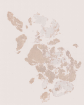

In [34]:
acth_slide2 = slide.open_slide(path_corticotrop/'lone-ly-III-ACTH.ndpi')
acth_level = len(acth_slide2.level_dimensions)-1
acth_slide2.read_region((0,0),
                     acth_level,
                     acth_slide2.level_dimensions[acth_level])

For `lone-ly-III-ACTH`, we actually don't seem to have a HE counterpart.

But we should take a closer look at `mul-ti-II-HE` and `mul-ti-III-ACTH`, seeing as how they are from the same case, only different fractions of it.

In [57]:
he_slide2 = slide.open_slide(path_corticotrop/'mul-ti-II-HE.ndpi')
acth_slide2 = slide.open_slide(path_corticotrop/'mul-ti-III-ACTH.ndpi')

In [58]:
acth_level = len(acth_slide2.level_dimensions)-1
acth_level

8

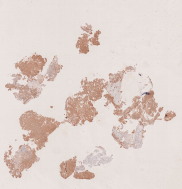

In [59]:
acth_slide2.read_region((0,0),
                     acth_level,
                     acth_slide2.level_dimensions[acth_level])

In [60]:
len(he_slide2.level_dimensions)

10

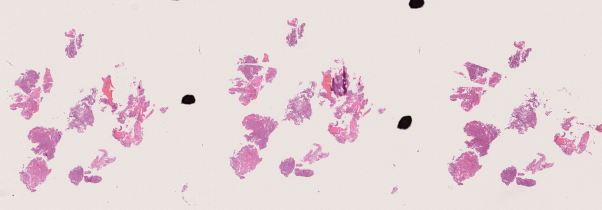

In [61]:
he_slide2.read_region((0,0),
                     acth_level,
                     he_slide2.level_dimensions[acth_level])

These two slides are obviously different from each other, but we might still be able to match the leftmost tissue in the HE slide with the tissue in the ACTH slide.

For the moment, we'll remove all three outliers from the list and remember to manually add case `mul-ti` later again when assigning slides to each other.

In [62]:
wsi_names_condensed_unique = [x for x in wsi_names_condensed_unique if wsi_names_condensed.count(x) != 1]
len(wsi_names_condensed_unique)

201

Again, let's see what happens when we strip the names of their fraction number:

In [63]:
wsi_names_two_numbers = []
for wsi_n_c_u in wsi_names_condensed_unique:
    m3 = re.search(
        '(.+)(\-.+)',
        wsi_n_c_u)
    if m3:
        wsi_names_two_numbers.append(m3.group(1))
    else:
        print("Couldn't match "+wsi_n_c_u)
wsi_names_two_numbers[:5]

How many unique case names are there?

In [64]:
wsi_names_two_numbers = list(set(wsi_names_two_numbers))
len(wsi_names_two_numbers)

179

That's interesting: Many cases seem to have more than one fraction name. Which ones?

In [ ]:
for wsi_n_t_n in wsi_names_two_numbers:
    startwith = []
    for wsi_n_c_u in wsi_names_condensed_unique:
        m4 = re.match(
        wsi_n_t_n.replace('-','\-') + '(\-.+)',
        wsi_n_c_u)
        if m4:
            startwith.append(wsi_n_c_u)
    if len(startwith)!=1:
        print(startwith)

Thus, there are some cases in which there are several fractions (Roman numbers) for one case.

We extend our quality control by looking at these fractions:

In [66]:
he_slide3 = slide.open_slide(path_corticotrop/'is-land-II-HE.ndpi')
acth_slide3 = slide.open_slide(path_corticotrop/'is-land-II-ACTH.ndpi')
he_slide4 = slide.open_slide(path_corticotrop/'is-land-III-HE.ndpi')
acth_slide4 = slide.open_slide(path_corticotrop/'is-land-III-ACTH.ndpi')

In [67]:
acth_level = len(acth_slide3.level_dimensions)-1
acth_level

8

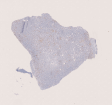

In [68]:
acth_slide3.read_region((0,0),
                     acth_level,
                     acth_slide3.level_dimensions[acth_level])

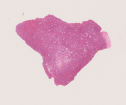

In [69]:
he_slide3.read_region((0,0),
                     acth_level,
                     he_slide3.level_dimensions[acth_level])

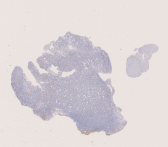

In [70]:
acth_slide4.read_region((0,0),
                     acth_level,
                     acth_slide4.level_dimensions[acth_level])

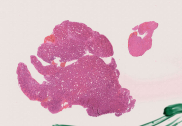

In [71]:
he_slide4.read_region((0,0),
                     acth_level,
                     he_slide4.level_dimensions[acth_level])

Alright, we determined exemplarily:
- Different fractions of the same case show different parts of the tissue and can be used independently of each other
- For the corticotropic slides, it is necessary to include the fraction number in the ID

We now save the IDs

In [72]:
with open(output_path/'wsi_cort_keys.txt', 'w') as f:
    for wsi_n_c_u in wsi_names_condensed_unique:
        print(wsi_n_c_u, file=f)  # Python 3.x

# creating a `pairlist`

Here's the earlier results again:

In [73]:
cort_keys = list(map(lambda str: str.replace('\n',''), open(output_path/'wsi_cort_keys.txt', 'r').readlines()))
gon_keys = list(map(lambda str: str.replace('\n',''), open(output_path/'wsi_gon_keys.txt', 'r').readlines()))

Next, we will create a list of dictionaries to assign any IHC filename to the filename of its respective HE counterpart.

In [74]:
pairlist = []

## Gonadotropic pairs

In [75]:
fnames = [f for f in pathlib.Path(path_gonadotrop).iterdir() if f.is_file()]
fnames.sort()
wsinames = []
for fname in fnames:
    m = re.search(
        '(?<=' + str(path_gonadotrop) + '/)(.+)\.ndpi',
        str(fname)
    )
    if m:
        wsinames.append({
            "slide name": m.group(1),
            "path": str(fname),
        })
wsinames[:5]

In [76]:
len(fnames), len(wsinames)

(862, 643)

In [ ]:
pairlist = []
for gkey in gon_keys:
    # get all slides with given gonadotropic key
    results = [(x["slide name"], x["path"]) for x in wsinames if re.match(gkey.replace('-','\-') + '\-.+', str(x["slide name"]))]
    # find the one slide with an HE stain
    he_tuple = [y for y in results if 'HE' in y[0]]
    for res in results: # dedicate a list element to all non-HE slides, and link them with the HE-slide
        if not 'HE' in res[0]:
            pairlist.append({
                "ihc name": res[0],
                "he name": he_tuple[0][0],
                "ihc path": res[1],
                "he path": he_tuple[0][1],
            })

In [ ]:
len(pairlist), pairlist[:3]

Let's check if we caught all of the IHC slides:

In [79]:
len([x for x in wsinames if 'HE' not in x["slide name"]])

414

Wonderful, the lists' lengths match.

Let's save the list and check if it was saved correctly:

In [80]:
pairlist[:2]

In [81]:
def dict_eq(a, b):
    shared_items = {k: a[k] for k in a if k in b and a[k] == b[k]}
    return len(shared_items) == len(a) and len(a) == len(b)

with open(output_path/'pairlist.txt', 'w') as f:
    for pair in pairlist:
        print(pair, file=f)  # Python 3.x
# this is how to read from a file a list of dictionaries:
pairlist_crtl = list(map(lambda str: eval(str.replace('\n','')), open(output_path/'pairlist.txt', 'r').readlines()))
equal_pairlists = True
for pair, ctrl_pair in zip(pairlist, pairlist_crtl):
    if not dict_eq(pair, ctrl_pair):
        equal_pairlists = False
equal_pairlists

True

Neat

## Corticotropic filenames

Let's use a different dictionary for quality control purposes first.

And let's recycle the code above:

In [82]:
fnames = [f for f in pathlib.Path(path_corticotrop).iterdir() if f.is_file()]
fnames.sort()
wsinames = []
for fname in fnames:
    m = re.search(
        '(?<=' + str(path_corticotrop) + '/)(.+)\.ndpi',
        str(fname)
    )
    if m:
        wsinames.append({
            "slide name": m.group(1),
            "path": str(fname),
        })
wsinames[:5]

In [83]:
len(wsinames)

405

In [84]:
cort_keys[:5]

In [85]:
tmp_pairlist = []
for ckey in cort_keys:
    # get all slides with given corticotropic key
    results = [(x["slide name"], x["path"]) for x in wsinames if re.match(ckey.replace('-','\-') + '\-.+', str(x["slide name"]))]
    # find the one slide with an HE stain
    he_tuple = [y for y in results if 'HE' in y[0]]
    for res in results: # dedicate a list element to all non-HE slides, and link them with the HE-slide
        if not 'HE' in res[0]:
            tmp_pairlist.append({
                "ihc name": res[0],
                "he name": he_tuple[0][0],
                "ihc path": res[1],
                "he path": he_tuple[0][1],
            })

In [86]:
len(tmp_pairlist), tmp_pairlist[:3]

Let's check if we caught all of the IHC slides:

In [87]:
len([x for x in wsinames if 'HE' not in x["slide name"]])

203

This time, two IHC slides were left out. Which ones?

In [88]:
[pair["ihc name"] for pair in tmp_pairlist][:5]

In [89]:
[x["slide name"] for x in wsinames 
     if x["slide name"] not in [pair["ihc name"] for pair in tmp_pairlist]
     and "HE" not in x["slide name"]]

In [90]:
for wsi_n_c_u in wsi_names_condensed_unique:
    if wsi_names_condensed.count(wsi_n_c_u) == 1:
        print("Found '" + wsi_n_c_u + "'")

From section 2 we remember that
- `lone-ly-III-ACTH` has no counterpart and thus is excluded, and
- `mul-ti-III-ACTH` has to be paired manually with `mul-ti-II-HE`, which we will do now:

In [91]:
[str(fn) for fn in fnames if 'mul-ti-II' in str(fn)]

In [92]:
tmp_pairlist.append({
    "ihc name": '826-18-III-ACTH',
    "he name": '826-18-II-HE',
    "ihc path": '/home/Deep_Learner/shared/Datasets/Hypophysenadenome/corticotrop/mul-ti-III-ACTH.ndpi',
    "he path": '/home/Deep_Learner/shared/Datasets/Hypophysenadenome/corticotrop/mul-ti-II-HE.ndpi',
})

Thus, we consider quality control successful and add everything to `pairlist`

In [93]:
print("length before:", len(pairlist))
print("length of tmp_pairlist:", len(tmp_pairlist))

pairlist = pairlist+tmp_pairlist

print("length after:", len(pairlist))

length before: 414
length of tmp_pairlist: 202
length after: 616


In [94]:
with open(output_path/'pairlist.txt', 'w') as f:
    for pair in pairlist:
        print(pair, file=f)  # Python 3.x
# let's also print a copy that we don't touch anymore from now on
with open(output_path/'pairlist_after_notebook_1.txt', 'w') as f:
    for pair in pairlist:
        print(pair, file=f)  # Python 3.x

One last quality check, to see if anything doesn't add up:

In [ ]:
for pair in pairlist:
    ihcName = pair["ihc name"]
    heName = pair["he name"]
    ihcCond = re.search(
        '(.+)(\-.+)',
        ihcName).group(1)
    heCond = re.search(
        '(.+)(\-.+)',
        heName).group(1)
    if ihcCond != heCond:
        print(ihcName + ": " + heName)

`Output:
abc-xyz-I-FSH: abc-xyz-Z-HE
lone-ly-III-ACTH: lone-ly-II-HE`

Those are the cases we checked earlier. Everything is in order.

# Converting `pairlist` to a dataframe

Maybe we will need a different format later:

In [96]:
import pandas as pd
df = pd.DataFrame.from_records(pairlist)
df.head(5)

In [97]:
# save, read, control
df.to_csv(output_path/'pairlist_df.csv', index=False)
df_new = pd.read_csv(output_path/'pairlist_df.csv')

df_new.head(5)

In [98]:
# as above, save a copy we won't touch any more:
df.to_csv(output_path/'pairlist_df_after_notebook_1.csv', index=False)